# **Gesture Recognition Case Study**

## **Problem Statement**

Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

Gesture	and its Corresponding Action:
1. Thumbs Up: Increase the volume.
2. Thumbs Down:	Decrease the volume.
3. Left Swipe:	'Jump' backwards 10 seconds.
4. Right Swipe:	'Jump' forward 10 seconds.
5. Stop:	Pause the movie.


Each video is a sequence of 30 frames (or images).

## **Objectives:**

* Generator: The generator should be able to take a batch of videos as input
without any error. Steps like cropping, resizing and normalization should be performed successfully.

* Model: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

* Write up: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model.

In [ ]:
# Checking the GPU configuration
!nvidia-smi

Mon Aug 14 05:15:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

###Importing the necessary libraries

In [1]:
# Importing required libraries

import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D, Conv3D, MaxPooling3D, AveragePooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.regularizers import l2
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN

We set the random seed so that the results don't vary drastically

In [2]:
# We set the random seed so that the results don't vary drastically.
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

Reading data for Training and Validations

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Unzip the dataset
!unzip "/content/gdrive/MyDrive/Project_data.zip" > /dev/null

In [5]:
# Define Location or Folder for datasets
project_folder = '/content/Project_data'

Visualizating Training and Validation w.r.t Accuracy and Loss

In [6]:
# For plotting graph for Training and Validation Loss as well as Accuracy
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
    plt.title("Training vs Validation w.r.t. Loss and Accuracy")
    axes[0].plot(history.history['loss'])
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['Training Loss','Validation Loss'])

    axes[1].plot(history.history['categorical_accuracy'])
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['Training Accuracy','Validation Accuracy'])

Here, we are using Objet Oriented Approach (Using Class and Methods) for defining class which will contains methods for initializing path and image properties as well as defining generators and also for defining models.
* Class: **ModelBuilder**
* Methods:
  1. **define_path():**
  
    Here, you read the folder names for training and validation.
  2. **define_image_properties():**

    Here, you set the image height and width.
  3. **define_hyperparams():**

    Here, you set batch size, number of epochs and number of frames.
  4. **train_generator():**
    
    Here, you preprocess i.e. resize and normalize images of two different dimensions as well as create a batch of video frames for Training data.
  5. **val_generator():**

    Here, you preprocess i.e. resize and normalize images of two different dimensions as well as create a batch of video frames for Training data.
  6. **define_model():**

    Here, you define layers for modelling.
  7. **train_model():**

    Here, you build and evaluate the model.

In [7]:
# Creating a Class

class ModelBuilder(metaclass= abc.ABCMeta):

    # Initialisng the path where project data resides
    def define_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())

        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'

        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        print("No.Folders for Training    : ",self.num_train_sequences)
        print("No.Folders for Validation  : ",self.num_val_sequences)

    # Initialising the image properties
    def define_image_properties(self,image_height=80,image_width=80):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
        print("Using Image Size(Width)    : ",self.image_width)
        print("Using Image Size(Height)   : ",self.image_height)
        print("No.Channels in Image       : ",self.channels)
        print("No.Output Classes          : ",self.num_classes)
        print("No.Available Total Frames  : ",self.total_frames)

    # Initialising the batch size, frames to sample and the no. of epochs
    def define_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        print("No.Frames for Model        : ",self.frames_to_sample)
        print("Batch Size                 : ",self.batch_size)
        print("No.Epochs                  : ",self.num_epochs)

    # We are defining two different generator function i.e for Training as well as Validation
    # The generator function
    def train_generator(self,source_path, folder_list):

        # We assume the frames between 7 and 20 are giving important infromation
        img_idx = np.round(np.linspace(7,20,self.frames_to_sample)).astype(int) #create a list of image numbers you want to use for a particular video
        print("List of Images for Training: ",img_idx)
        batch_size=self.batch_size

        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(folder_list)//batch_size  # calculate the number of batches

            for batch in range(num_batches):
                batch_data = np.zeros((batch_size,len(img_idx),self.image_height,self.image_width,3))
                batch_labels = np.zeros((batch_size,5))
                for folder in range(batch_size): # iterate over the batch_size
                    imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                    for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                        image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                        image = resize(image,(self.image_height,self.image_width))
                        image = image - np.percentile(image,5)/ np.percentile(image,95) - np.percentile(image,5)
                        batch_data[folder,idx,:,:,0] = image[:,:,0]
                        batch_data[folder,idx,:,:,1] = image[:,:,1]
                        batch_data[folder,idx,:,:,2] = image[:,:,2]

                    batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            rem_image = len(folder_list)%batch_size
            batch += 1
            if(rem_image!=0):
                batch_data = np.zeros((rem_image,len(img_idx),self.image_height,self.image_width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
                batch_labels = np.zeros((rem_image,5)) # batch_labels is the one hot representation of the output
                for folder in range(rem_image): # iterate over the batch_size
                    imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                    for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                        image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                        image = resize(image,(self.image_height,self.image_width))
                        image = image - np.percentile(image,5)/ np.percentile(image,95) - np.percentile(image,5)
                        batch_data[folder,idx,:,:,0] = image[:,:,0]
                        batch_data[folder,idx,:,:,1] = image[:,:,1]
                        batch_data[folder,idx,:,:,2] = image[:,:,2]

                    batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                yield batch_data, batch_labels


    def val_generator(self,source_path, folder_list):

        # We assume that frames between 8 and 24 are giving important information
        img_idx = np.round(np.linspace(8,24,self.frames_to_sample)).astype(int) #create a list of image numbers you want to use for a particular video
        print("List Images for Validation : ",img_idx)
        batch_size=self.batch_size

        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(folder_list)//batch_size  # calculate the number of batches

            for batch in range(num_batches):
                batch_data = np.zeros((batch_size,len(img_idx),self.image_height,self.image_width,3))
                batch_labels = np.zeros((batch_size,5))
                for folder in range(batch_size): # iterate over the batch_size
                    imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                    for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                        image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                        image = resize(image,(self.image_height,self.image_width))
                        image = image - np.percentile(image,5)/ np.percentile(image,95) - np.percentile(image,5)
                        batch_data[folder,idx,:,:,0] = image[:,:,0]
                        batch_data[folder,idx,:,:,1] = image[:,:,1]
                        batch_data[folder,idx,:,:,2] = image[:,:,2]

                    batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            rem_image = len(folder_list)%batch_size
            batch += 1
            if(rem_image!=0):
                batch_data = np.zeros((rem_image,len(img_idx),self.image_height,self.image_width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
                batch_labels = np.zeros((rem_image,5)) # batch_labels is the one hot representation of the output
                for folder in range(rem_image): # iterate over the batch_size
                    imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                    for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                        image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                        image = resize(image,(self.image_height,self.image_width))
                        image = image - np.percentile(image,5)/ np.percentile(image,95) - np.percentile(image,5)
                        batch_data[folder,idx,:,:,0] = image[:,:,0]
                        batch_data[folder,idx,:,:,1] = image[:,:,1]
                        batch_data[folder,idx,:,:,2] = image[:,:,2]

                    batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                yield batch_data, batch_labels


    def train_model(self, model, augment_data=False):
        train_generator = self.train_generator(self.train_path, self.train_doc)
        val_generator = self.val_generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'

        if not os.path.exists(model_name):
            os.mkdir(model_name)

        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=5)

        earlystop = EarlyStopping(monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1

        print("Training Steps per epoch   : ",steps_per_epoch)
        print("Validation Steps per epoch : ",validation_steps)

        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,
                            callbacks=callbacks_list, validation_data=val_generator,
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history


    @abc.abstractmethod
    def define_model(self):
        pass

Define Layers for Models

In [ ]:
class ModelConv3D1(ModelBuilder):

    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (2,2,2), padding='same',input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2,2,2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2,2,2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2,2,2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(1, 2, 2)))

        model.add(Flatten())
        model.add(Dense(256,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(256,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))


        model.add(Dense(5,activation='softmax'))

        # compiler
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(loss='categorical_crossentropy', optimizer=optimiser, metrics=['categorical_accuracy'])

        return model

### **Model1:** Image Size: 75*75, Batch Size: 30, Epochs: 10, Frames per Sample: 14 with less number of Model Parameter

In [ ]:
Model1=ModelConv3D1()
Model1.define_path(project_folder)
Model1.define_image_properties(image_height=75,image_width=75)
Model1.define_hyperparams(frames_to_sample=14,batch_size=30,num_epochs=10)
conv_3d1_model1=Model1.define_model()
print("Total Params:", conv_3d1_model1.count_params())
conv_3d1_model1.summary()
history_model1 = Model1.train_model(conv_3d1_model1)

No.Folders for Training    :  663
No.Folders for Validation  :  100
Using Image Size(Width)    :  75
Using Image Size(Height)   :  75
No.Channels in Image       :  3
No.Output Classes          :  5
No.Available Total Frames  :  30
No.Frames for Model        :  14
Batch Size                 :  30
No.Epochs                  :  10
Total Params: 681269
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 14, 75, 75, 16)    400       
                                                                 
 activation_8 (Activation)   (None, 14, 75, 75, 16)    0         
                                                                 
 batch_normalization_12 (Bat  (None, 14, 75, 75, 16)   64        
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (No

Training Steps per epoch   :  23
Validation Steps per epoch :  4
List of Images for Training:  [ 7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Epoch 1/10
23/23 [==============================] - ETA: 0s - loss: 2.3726 - categorical_accuracy: 0.2805List Images for Validation :  [ 8  9 10 12 13 14 15 17 18 19 20 22 23 24]

Epoch 1: val_loss improved from inf to 1.70228, saving model to model_init_2023-08-1405_53_07.151639/model-00001-2.37257-0.28054-1.70228-0.24000.h5
23/23 [==============================] - 106s 4s/step - loss: 2.3726 - categorical_accuracy: 0.2805 - val_loss: 1.7023 - val_categorical_accuracy: 0.2400 - lr: 2.0000e-04
Epoch 2/10
23/23 [==============================] - ETA: 0s - loss: 1.6835 - categorical_accuracy: 0.4103
Epoch 2: val_loss did not improve from 1.70228
23/23 [==============================] - 96s 4s/step - loss: 1.6835 - categorical_accuracy: 0.4103 - val_loss: 1.9223 - val_categorical_accuracy: 0.2400 - lr: 2.0000e-04
Epoch 3/10
23/23 [=====================

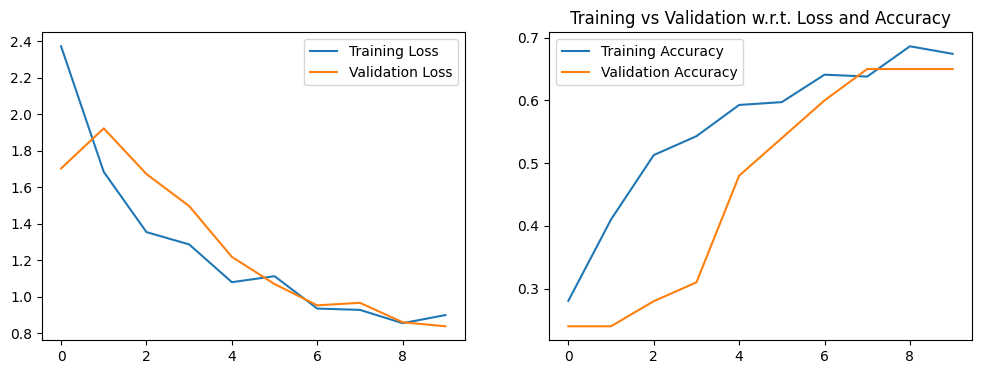

In [ ]:
# Plotting Graph for Accuracy and Loss
plot(history_model1)

**Insights:**
1. We have built model with less parameters with low number of epochs and batch size.
2. We have received Training and Valiadation accuracy approx. 68% and 65%
3. For one of epoch, we have received Validation Accuracy more tha that of Training Accuracy.

### **Model2:** Image Size: 75*75, Batch Size: 30, Epochs: 20, Frames per Sample: 14 with less number of Model Parameter

In [ ]:
Model2=ModelConv3D1()
Model2.define_path(project_folder)
Model2.define_image_properties(image_height=75,image_width=75)
Model2.define_hyperparams(frames_to_sample=14,batch_size=30,num_epochs=20)
conv_3d1_model2=Model2.define_model()
print("Total Params:", conv_3d1_model2.count_params())
conv_3d1_model2.summary()
history_model2 = Model2.train_model(conv_3d1_model2)

No.Folders for Training    :  663
No.Folders for Validation  :  100
Using Image Size(Width)    :  75
Using Image Size(Height)   :  75
No.Channels in Image       :  3
No.Output Classes          :  5
No.Available Total Frames  :  30
No.Frames for Model        :  14
Batch Size                 :  30
No.Epochs                  :  20
Total Params: 681269
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 14, 75, 75, 16)    400       
                                                                 
 activation_12 (Activation)  (None, 14, 75, 75, 16)    0         
                                                                 
 batch_normalization_18 (Bat  (None, 14, 75, 75, 16)   64        
 chNormalization)                                                
                                                                 
 max_pooling3d_12 (MaxPoolin  (No

Training Steps per epoch   :  23
Validation Steps per epoch :  4
List of Images for Training:  [ 7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 2.5285 - categorical_accuracy: 0.2474List Images for Validation :  [ 8  9 10 12 13 14 15 17 18 19 20 22 23 24]

Epoch 1: val_loss improved from inf to 2.02685, saving model to model_init_2023-08-1406_16_19.432429/model-00001-2.52853-0.24736-2.02685-0.24000.h5
23/23 [==============================] - 98s 4s/step - loss: 2.5285 - categorical_accuracy: 0.2474 - val_loss: 2.0269 - val_categorical_accuracy: 0.2400 - lr: 2.0000e-04
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 1.8205 - categorical_accuracy: 0.3952
Epoch 2: val_loss improved from 2.02685 to 1.92810, saving model to model_init_2023-08-1406_16_19.432429/model-00002-1.82049-0.39517-1.92810-0.27000.h5
23/23 [==============================] - 97s 4s/step - loss: 1.8205 - categorical_accuracy: 0.3952 - val_

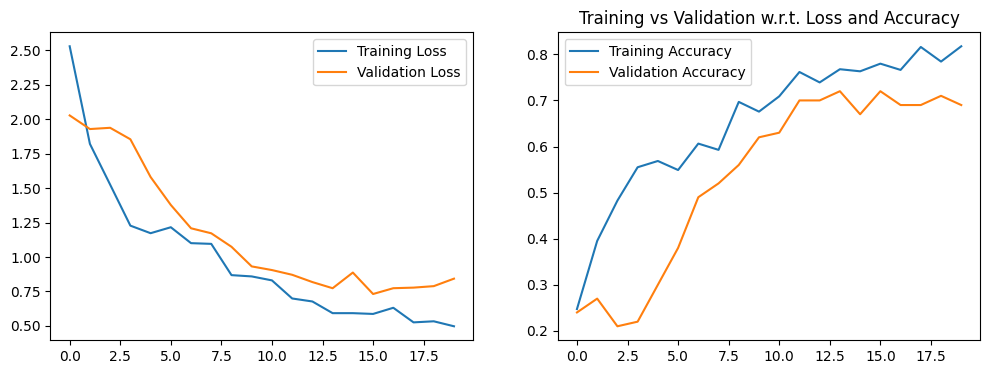

In [ ]:
# Plotting Graph for Accuarcy and Graph
plot(history_model2)

**Insights:**
1. We have built model with less parameters with epochs = 20 and batch size.
2. We have received Training and Valiadation accuracy approx. 82% and 70%
3. One of Epoch, we have received 77% Training and 72% Validation Accuracy.

### **Model3:** Image Size: 75*75, Batch Size: 50, Epochs: 10, Frames per Sample: 14 with less number of Model Parameter

In [ ]:
Model3=ModelConv3D1()
Model3.define_path(project_folder)
Model3.define_image_properties(image_height=75,image_width=75)
Model3.define_hyperparams(frames_to_sample=14,batch_size=50,num_epochs=10)
conv_3d1_model3=Model3.define_model()
print("Total Params:", conv_3d1_model3.count_params())
conv_3d1_model3.summary()
history_model3 = Model3.train_model(conv_3d1_model3)

No.Folders for Training    :  663
No.Folders for Validation  :  100
Using Image Size(Width)    :  75
Using Image Size(Height)   :  75
No.Channels in Image       :  3
No.Output Classes          :  5
No.Available Total Frames  :  30
No.Frames for Model        :  14
Batch Size                 :  50
No.Epochs                  :  10
Total Params: 681269
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 14, 75, 75, 16)    400       
                                                                 
 activation_16 (Activation)  (None, 14, 75, 75, 16)    0         
                                                                 
 batch_normalization_24 (Bat  (None, 14, 75, 75, 16)   64        
 chNormalization)                                                
                                                                 
 max_pooling3d_16 (MaxPoolin  (No

Training Steps per epoch   :  14
Validation Steps per epoch :  2
List of Images for Training:  [ 7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Epoch 1/10
14/14 [==============================] - ETA: 0s - loss: 2.4851 - categorical_accuracy: 0.2594List Images for Validation :  [ 8  9 10 12 13 14 15 17 18 19 20 22 23 24]

Epoch 1: val_loss improved from inf to 2.89404, saving model to model_init_2023-08-1406_49_47.303914/model-00001-2.48507-0.25943-2.89404-0.23000.h5
14/14 [==============================] - 105s 8s/step - loss: 2.4851 - categorical_accuracy: 0.2594 - val_loss: 2.8940 - val_categorical_accuracy: 0.2300 - lr: 2.0000e-04
Epoch 2/10
14/14 [==============================] - ETA: 0s - loss: 1.7948 - categorical_accuracy: 0.4027
Epoch 2: val_loss did not improve from 2.89404
14/14 [==============================] - 102s 8s/step - loss: 1.7948 - categorical_accuracy: 0.4027 - val_loss: 2.9638 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 3/10
14/14 [====================

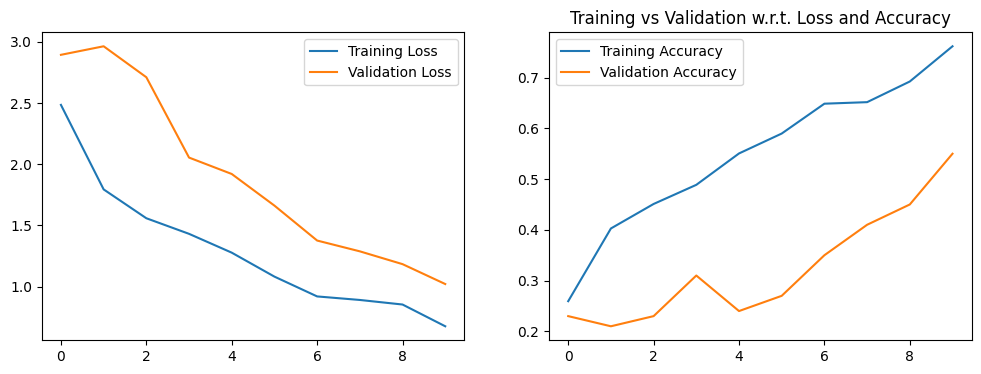

In [ ]:
# Plotting Graph for Accuracy and Loss
plot(history_model3)

**Insights:**
1. We have built model with less parameters with low number of epochs and batch size = 50.
2. We have received Training and Valiadation accuracy approx. 75% and 50%
3. It is overfitting model.

### **Model4:** Image Size: 75*75, Batch Size: 50, Epochs: 20, Frames per Sample: 14 with less number of Model Parameter

In [ ]:
Model4=ModelConv3D1()
Model4.define_path(project_folder)
Model4.define_image_properties(image_height=75,image_width=75)
Model4.define_hyperparams(frames_to_sample=14,batch_size=50,num_epochs=20)
conv_3d1_model4=Model4.define_model()
print("Total Params:", conv_3d1_model4.count_params())
conv_3d1_model4.summary()
history_model4 = Model4.train_model(conv_3d1_model4)

No.Folders for Training    :  663
No.Folders for Validation  :  100
Using Image Size(Width)    :  75
Using Image Size(Height)   :  75
No.Channels in Image       :  3
No.Output Classes          :  5
No.Available Total Frames  :  30
No.Frames for Model        :  14
Batch Size                 :  50
No.Epochs                  :  20
Total Params: 681269
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 14, 75, 75, 16)    400       
                                                                 
 activation_20 (Activation)  (None, 14, 75, 75, 16)    0         
                                                                 
 batch_normalization_30 (Bat  (None, 14, 75, 75, 16)   64        
 chNormalization)                                                
                                                                 
 max_pooling3d_20 (MaxPoolin  (No

Training Steps per epoch   :  14
Validation Steps per epoch :  2
List of Images for Training:  [ 7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Epoch 1/20
14/14 [==============================] - ETA: 0s - loss: 2.4819 - categorical_accuracy: 0.2398List Images for Validation :  [ 8  9 10 12 13 14 15 17 18 19 20 22 23 24]

Epoch 1: val_loss improved from inf to 1.96474, saving model to model_init_2023-08-1407_06_31.570809/model-00001-2.48190-0.23982-1.96474-0.23000.h5
14/14 [==============================] - 97s 7s/step - loss: 2.4819 - categorical_accuracy: 0.2398 - val_loss: 1.9647 - val_categorical_accuracy: 0.2300 - lr: 2.0000e-04
Epoch 2/20
14/14 [==============================] - ETA: 0s - loss: 1.9471 - categorical_accuracy: 0.3544
Epoch 2: val_loss did not improve from 1.96474
14/14 [==============================] - 95s 7s/step - loss: 1.9471 - categorical_accuracy: 0.3544 - val_loss: 2.0010 - val_categorical_accuracy: 0.2300 - lr: 2.0000e-04
Epoch 3/20
14/14 [======================

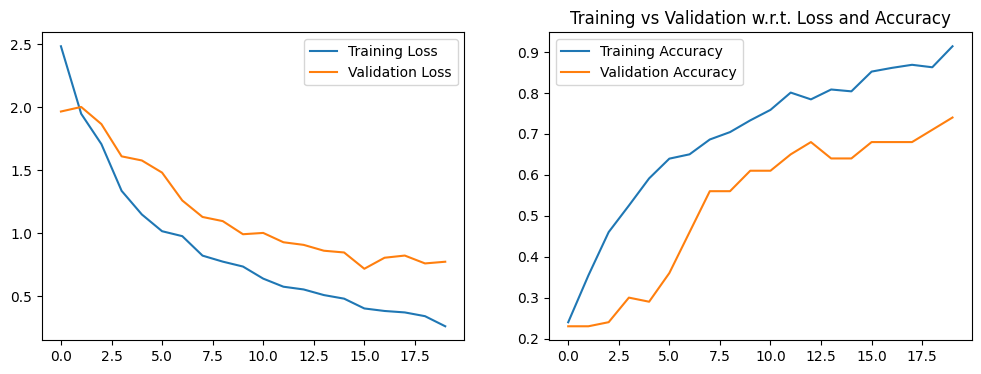

In [ ]:
#Plotting Graph for Accuracy and Loss
plot(history_model4)

**Insights:**
1. We have built model with less parameters with epochs = 20 and batch size = 50.
2. We have received Training and Valiadation accuracy approx. 90% and 70%

### **Model5:** Image Size: 75*75, Batch Size: 50, Epochs: 20, Frames per Sample: 14 with less number of Model Parameter
**Increasing Filtersize and Dense = 64 and Dropout = 0.25**

In [ ]:
class ModelConv3D2(ModelBuilder):

    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3,3,3), padding='same',
                input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3,3,3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (3,3,3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (3,3,3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(1, 2, 2)))

        model.add(Flatten())
        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(5,activation='softmax'))

        # compiler
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(loss='categorical_crossentropy', optimizer=optimiser, metrics=['categorical_accuracy'])

        return model

In [ ]:
Model5=ModelConv3D2()
Model5.define_path(project_folder)
Model5.define_image_properties(image_height=75,image_width=75)
Model5.define_hyperparams(frames_to_sample=14,batch_size=50,num_epochs=20)
conv_3d1_model5=Model5.define_model()
print("Total Params:", conv_3d1_model5.count_params())
conv_3d1_model5.summary()
history_model5 = Model5.train_model(conv_3d1_model5)

No.Folders for Training    :  663
No.Folders for Validation  :  100
Using Image Size(Width)    :  75
Using Image Size(Height)   :  75
No.Channels in Image       :  3
No.Output Classes          :  5
No.Available Total Frames  :  30
No.Frames for Model        :  14
Batch Size                 :  50
No.Epochs                  :  20
Total Params: 428933
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_28 (Conv3D)          (None, 14, 75, 75, 16)    1312      
                                                                 
 activation_28 (Activation)  (None, 14, 75, 75, 16)    0         
                                                                 
 batch_normalization_42 (Bat  (None, 14, 75, 75, 16)   64        
 chNormalization)                                                
                                                                 
 max_pooling3d_28 (MaxPoolin  (No

Training Steps per epoch   :  14
Validation Steps per epoch :  2
List of Images for Training:  [ 7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Epoch 1/20
14/14 [==============================] - ETA: 0s - loss: 2.0563 - categorical_accuracy: 0.2745List Images for Validation :  [ 8  9 10 12 13 14 15 17 18 19 20 22 23 24]

Epoch 1: val_loss improved from inf to 1.74949, saving model to model_init_2023-08-1407_47_52.888109/model-00001-2.05635-0.27451-1.74949-0.21000.h5
14/14 [==============================] - 97s 7s/step - loss: 2.0563 - categorical_accuracy: 0.2745 - val_loss: 1.7495 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/20
14/14 [==============================] - ETA: 0s - loss: 1.3461 - categorical_accuracy: 0.4585
Epoch 2: val_loss did not improve from 1.74949
14/14 [==============================] - 93s 7s/step - loss: 1.3461 - categorical_accuracy: 0.4585 - val_loss: 1.7564 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 3/20
14/14 [======================

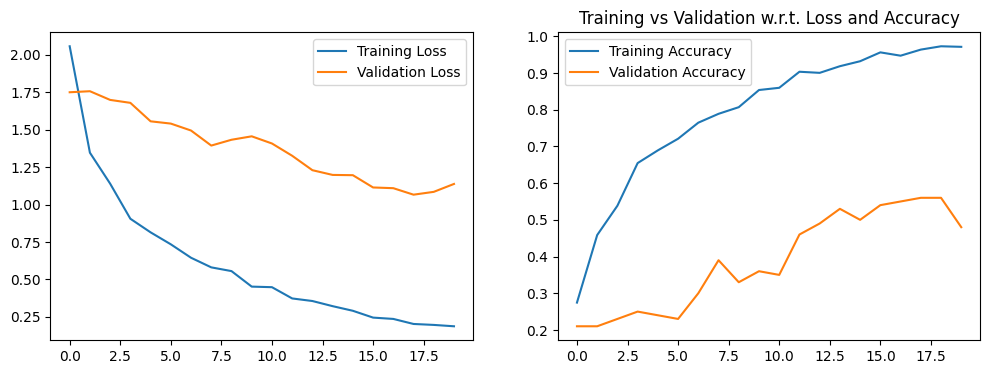

In [ ]:
#Plottingg Graph for Accuracy and Loss
plot(history_model5)

**Insights:**
1. It is overfitted model.
2. It is giving approx. 98% Training Accuracy and 48% Validation Accuracy.

### **Model6:** Image Size: 75*75, Batch Size: 50, Epochs: 20, Frames per Sample: 14 with less number of Model Parameter
**Increasing Filtersize and Dense = 64 and Dropout = 0.25**

**Removing Batch Normalization Layers**

In [ ]:
class ModelConv3D3(ModelBuilder):

    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3,3,3), padding='same',
                input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        #model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3,3,3), padding='same'))
        model.add(Activation('relu'))
        #model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (3,3,3), padding='same'))
        model.add(Activation('relu'))
        #model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (3,3,3), padding='same'))
        model.add(Activation('relu'))
        #model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(1, 2, 2)))

        model.add(Flatten())
        model.add(Dense(64,activation='relu'))
        #model.add(BatchNormalization())
        model.add(Dropout(0.25))

        model.add(Dense(64,activation='relu'))
        #model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(5,activation='softmax'))

        # compiler
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(loss='categorical_crossentropy', optimizer=optimiser, metrics=['categorical_accuracy'])

        return model

In [ ]:
Model6=ModelConv3D3()
Model6.define_path(project_folder)
Model6.define_image_properties(image_height=75,image_width=75)
Model6.define_hyperparams(frames_to_sample=14,batch_size=50,num_epochs=20)
conv_3d1_model6=Model6.define_model()
print("Total Params:", conv_3d1_model6.count_params())
conv_3d1_model6.summary()
history_model6 = Model6.train_model(conv_3d1_model6)

No.Folders for Training    :  663
No.Folders for Validation  :  100
Using Image Size(Width)    :  75
Using Image Size(Height)   :  75
No.Channels in Image       :  3
No.Output Classes          :  5
No.Available Total Frames  :  30
No.Frames for Model        :  14
Batch Size                 :  50
No.Epochs                  :  20
Total Params: 427461
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_32 (Conv3D)          (None, 14, 75, 75, 16)    1312      
                                                                 
 activation_32 (Activation)  (None, 14, 75, 75, 16)    0         
                                                                 
 max_pooling3d_32 (MaxPoolin  (None, 7, 37, 37, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_33 (Conv3D)          (Non

Training Steps per epoch   :  14
Validation Steps per epoch :  2
List of Images for Training:  [ 7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Epoch 1/20
14/14 [==============================] - ETA: 0s - loss: 3.9014 - categorical_accuracy: 0.1885List Images for Validation :  [ 8  9 10 12 13 14 15 17 18 19 20 22 23 24]

Epoch 1: val_loss improved from inf to 1.57960, saving model to model_init_2023-08-1408_31_57.195724/model-00001-3.90136-0.18854-1.57960-0.29000.h5
14/14 [==============================] - 102s 8s/step - loss: 3.9014 - categorical_accuracy: 0.1885 - val_loss: 1.5796 - val_categorical_accuracy: 0.2900 - lr: 2.0000e-04
Epoch 2/20
14/14 [==============================] - ETA: 0s - loss: 1.6106 - categorical_accuracy: 0.2097
Epoch 2: val_loss improved from 1.57960 to 1.57854, saving model to model_init_2023-08-1408_31_57.195724/model-00002-1.61055-0.20965-1.57854-0.21000.h5
14/14 [==============================] - 105s 8s/step - loss: 1.6106 - categorical_accuracy: 0.2097 - va

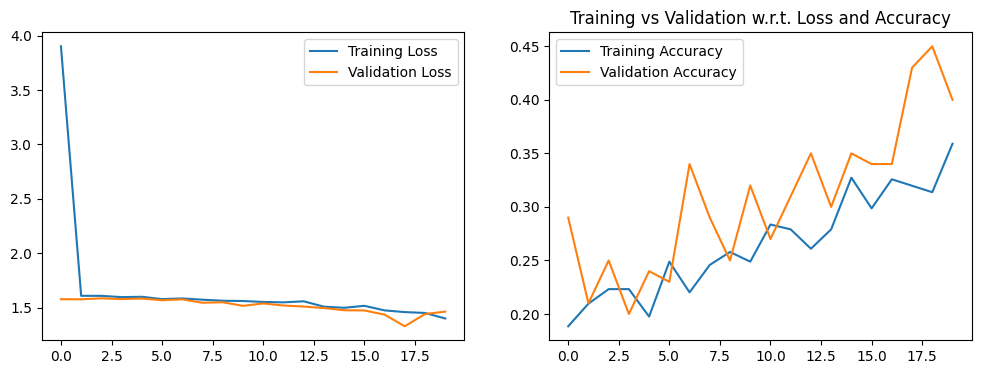

In [ ]:
#Plotting Graph for Accuracy and Loss
plot(history_model6)

**Insights:**
1. It is underfitted model.
2. It is giving Training Accuracy and Validation Accuracy as approx. 40% and 35%

### **Model7:** Image Size: 75*75, Batch Size: 50, Epochs: 20, Frames per Sample: 14 with less number of Model Parameter

**decreasing Filtersize and Dense = 256 and Dropout = 0.25 and 0.5**


**Adding Droput at Convolution Layer**

In [ ]:
class ModelConv3D4(ModelBuilder):

    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (2,2,2), padding='same',
                input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(0.25))

        model.add(Conv3D(32, (2,2,2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(0.25))

        model.add(Conv3D(64, (2,2,2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(0.25))

        model.add(Conv3D(128, (2,2,2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(1, 2, 2)))
        model.add(Dropout(0.25))

        model.add(Flatten())
        model.add(Dense(256,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(256,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))


        model.add(Dense(5,activation='softmax'))

        # compiler
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(loss='categorical_crossentropy', optimizer=optimiser, metrics=['categorical_accuracy'])

        return model

In [ ]:
Model7=ModelConv3D4()
Model7.define_path(project_folder)
Model7.define_image_properties(image_height=75,image_width=75)
Model7.define_hyperparams(frames_to_sample=14,batch_size=50,num_epochs=20)
conv_3d1_model7=Model7.define_model()
print("Total Params:", conv_3d1_model7.count_params())
conv_3d1_model7.summary()
history_model7 = Model7.train_model(conv_3d1_model7)

No.Folders for Training    :  663
No.Folders for Validation  :  100
Using Image Size(Width)    :  75
Using Image Size(Height)   :  75
No.Channels in Image       :  3
No.Output Classes          :  5
No.Available Total Frames  :  30
No.Frames for Model        :  14
Batch Size                 :  50
No.Epochs                  :  20
Total Params: 681269
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_36 (Conv3D)          (None, 14, 75, 75, 16)    400       
                                                                 
 activation_36 (Activation)  (None, 14, 75, 75, 16)    0         
                                                                 
 batch_normalization_48 (Bat  (None, 14, 75, 75, 16)   64        
 chNormalization)                                                
                                                                 
 max_pooling3d_36 (MaxPoolin  (No

Training Steps per epoch   :  14
Validation Steps per epoch :  2
List of Images for Training:  [ 7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Epoch 1/20
14/14 [==============================] - ETA: 0s - loss: 2.9043 - categorical_accuracy: 0.1946List Images for Validation :  [ 8  9 10 12 13 14 15 17 18 19 20 22 23 24]

Epoch 1: val_loss improved from inf to 1.93341, saving model to model_init_2023-08-1409_04_36.302934/model-00001-2.90433-0.19457-1.93341-0.23000.h5
14/14 [==============================] - 110s 8s/step - loss: 2.9043 - categorical_accuracy: 0.1946 - val_loss: 1.9334 - val_categorical_accuracy: 0.2300 - lr: 2.0000e-04
Epoch 2/20
14/14 [==============================] - ETA: 0s - loss: 2.4990 - categorical_accuracy: 0.2519
Epoch 2: val_loss improved from 1.93341 to 1.70864, saving model to model_init_2023-08-1409_04_36.302934/model-00002-2.49903-0.25189-1.70864-0.26000.h5
14/14 [==============================] - 109s 8s/step - loss: 2.4990 - categorical_accuracy: 0.2519 - va

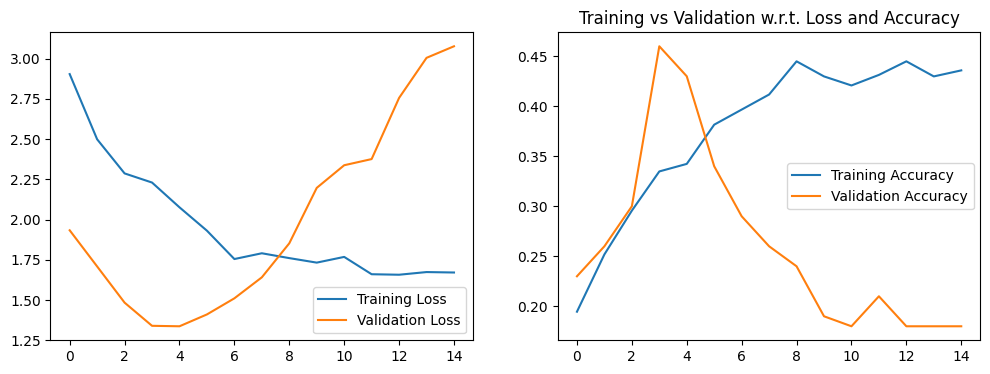

In [ ]:
# Ploting Graph for Accuracy and Loss
plot(history_model7)

**Insights:**
1. It is underfitted model.
2. It is giving approx. 45% Training and 20% Valication Accuracy.

### **Model8:** Image Size: 75*75, Batch Size: 50, Epochs: 20, Frames per Sample: 14

**CNN- LSTM Model**

In [ ]:
class ModelConv3D5(ModelBuilder):

    def define_model(self):

        model = Sequential()
        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(64))
        model.add(Dropout(0.25))

        model.add(Dense(64,activation='relu'))
        model.add(Dropout(0.25))

        model.add(Dense(5, activation='softmax'))

        # compiler
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(loss='categorical_crossentropy', optimizer=optimiser, metrics=['categorical_accuracy'])

        return model

In [ ]:
Model8=ModelConv3D5()
Model8.define_path(project_folder)
Model8.define_image_properties(image_height=75,image_width=75)
Model8.define_hyperparams(frames_to_sample=14,batch_size=50,num_epochs=20)
conv_3d1_model8=Model8.define_model()
print("Total Params:", conv_3d1_model8.count_params())
conv_3d1_model8.summary()
history_model8 = Model8.train_model(conv_3d1_model8)

No.Folders for Training    :  663
No.Folders for Validation  :  100
Using Image Size(Width)    :  75
Using Image Size(Height)   :  75
No.Channels in Image       :  3
No.Output Classes          :  5
No.Available Total Frames  :  30
No.Frames for Model        :  14
Batch Size                 :  50
No.Epochs                  :  20
Total Params: 677861
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 14, 75, 75, 16)   448       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 14, 75, 75, 16)   64        
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 14, 37, 37, 16)   0         
 tributed)                      

Training Steps per epoch   :  14
Validation Steps per epoch :  2
List of Images for Training:  [ 7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Epoch 1/20
14/14 [==============================] - ETA: 0s - loss: 1.5656 - categorical_accuracy: 0.3062List Images for Validation :  [ 8  9 10 12 13 14 15 17 18 19 20 22 23 24]

Epoch 1: val_loss improved from inf to 1.67611, saving model to model_init_2023-08-1409_43_47.109477/model-00001-1.56563-0.30618-1.67611-0.22000.h5
14/14 [==============================] - 100s 7s/step - loss: 1.5656 - categorical_accuracy: 0.3062 - val_loss: 1.6761 - val_categorical_accuracy: 0.2200 - lr: 2.0000e-04
Epoch 2/20
14/14 [==============================] - ETA: 0s - loss: 1.2769 - categorical_accuracy: 0.5264
Epoch 2: val_loss did not improve from 1.67611
14/14 [==============================] - 98s 8s/step - loss: 1.2769 - categorical_accuracy: 0.5264 - val_loss: 1.8863 - val_categorical_accuracy: 0.2200 - lr: 2.0000e-04
Epoch 3/20
14/14 [=====================

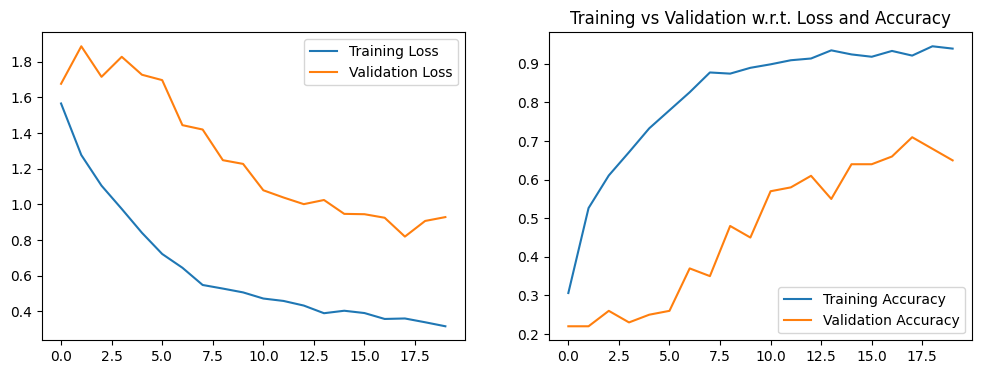

In [ ]:
# Plotting Graph for Accuracy and Loss
plot(history_model8)

**Insights:**
1. It is giving approx. 95% Training Accuracy and 65% Validation Accuracy.
2. It is still Overfitted Model.

### **Model9:** Image Size: 120*120, Batch Size: 20, Epochs: 20, Frames per Sample: 18

**CNN- LSTM Model**

In [ ]:
class ModelConv3D6(ModelBuilder):

    def define_model(self):

        model = Sequential()
        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(64))
        model.add(Dropout(0.25))

        model.add(Dense(64,activation='relu'))
        model.add(Dropout(0.25))

        model.add(Dense(5, activation='softmax'))

        # compiler
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(loss='categorical_crossentropy', optimizer=optimiser, metrics=['categorical_accuracy'])

        return model

In [ ]:
Model9=ModelConv3D6()
Model9.define_path(project_folder)
Model9.define_image_properties(image_height=120,image_width=120)
Model9.define_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
conv_3d1_model9=Model9.define_model()
print("Total Params:", conv_3d1_model9.count_params())
conv_3d1_model9.summary()
history_model9 = Model9.train_model(conv_3d1_model9)

No.Folders for Training    :  663
No.Folders for Validation  :  100
Using Image Size(Width)    :  120
Using Image Size(Height)   :  120
No.Channels in Image       :  3
No.Output Classes          :  5
No.Available Total Frames  :  30
No.Frames for Model        :  18
Batch Size                 :  20
No.Epochs                  :  20
Total Params: 1005541
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 18, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 18, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 18, 60, 60, 16)   0         
 stributed)                  

Training Steps per epoch   :  34
Validation Steps per epoch :  5
List of Images for Training:  [ 7  8  9  9 10 11 12 12 13 14 15 15 16 17 18 18 19 20]
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.5600 - categorical_accuracy: 0.2790List Images for Validation :  [ 8  9 10 11 12 13 14 15 16 16 17 18 19 20 21 22 23 24]

Epoch 1: val_loss improved from inf to 1.61762, saving model to model_init_2023-08-1410_24_45.057350/model-00001-1.56000-0.27903-1.61762-0.23000.h5
34/34 [==============================] - 160s 5s/step - loss: 1.5600 - categorical_accuracy: 0.2790 - val_loss: 1.6176 - val_categorical_accuracy: 0.2300 - lr: 2.0000e-04
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.2956 - categorical_accuracy: 0.4932
Epoch 2: val_loss did not improve from 1.61762
34/34 [==============================] - 160s 5s/step - loss: 1.2956 - categorical_accuracy: 0.4932 - val_loss: 1.7069 - val_categorical_accuracy: 0.2000 - lr: 2.0000e-04
Epoch 3/20
34/

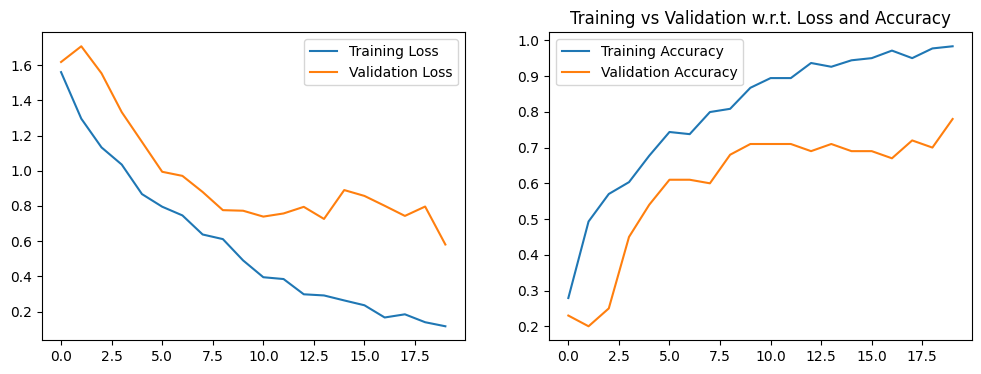

In [ ]:
# Plotting Graph for Accuracy and Loss
plot(history_model9)

**Insights:**
1. There is improvement in the model.
2. It is giving approx. 98% Training and 75% Validation Accuracy.
3. In 20th Epoch, we have received 98% and 78% Accuracy.

### **Model10:** Image Size: 120*120, Batch Size: 20, Epochs: 20, Frames per Sample: 18

In [ ]:
Model10=ModelConv3D1()
Model10.define_path(project_folder)
Model10.define_image_properties(image_height=120,image_width=120)
Model10.define_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
conv_3d1_model10=Model10.define_model()
print("Total Params:", conv_3d1_model10.count_params())
conv_3d1_model10.summary()
history_model10 = Model10.train_model(conv_3d1_model10)

No.Folders for Training    :  663
No.Folders for Validation  :  100
Using Image Size(Width)    :  120
Using Image Size(Height)   :  120
No.Channels in Image       :  3
No.Output Classes          :  5
No.Available Total Frames  :  30
No.Frames for Model        :  18
Batch Size                 :  20
No.Epochs                  :  20
Total Params: 3368245
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 18, 120, 120, 16)  400       
                                                                 
 activation (Activation)     (None, 18, 120, 120, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 18, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (N

Training Steps per epoch   :  34
Validation Steps per epoch :  5
List of Images for Training:  [ 7  8  9  9 10 11 12 12 13 14 15 15 16 17 18 18 19 20]
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 2.1542 - categorical_accuracy: 0.3198List Images for Validation :  [ 8  9 10 11 12 13 14 15 16 16 17 18 19 20 21 22 23 24]

Epoch 1: val_loss improved from inf to 6.56582, saving model to model_init_2023-08-1413_21_48.571045/model-00001-2.15423-0.31976-6.56582-0.23000.h5
34/34 [==============================] - 156s 4s/step - loss: 2.1542 - categorical_accuracy: 0.3198 - val_loss: 6.5658 - val_categorical_accuracy: 0.2300 - lr: 2.0000e-04
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.1594 - categorical_accuracy: 0.5671
Epoch 2: val_loss improved from 6.56582 to 3.21696, saving model to model_init_2023-08-1413_21_48.571045/model-00002-1.15939-0.56712-3.21696-0.25000.h5
34/34 [==============================] - 160s 5s/step - loss: 1.1594 - categoric

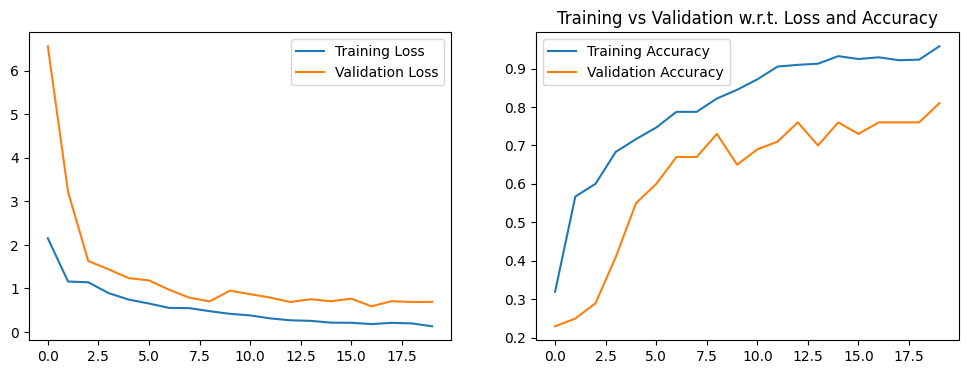

In [ ]:
# Plotting Graph for Accuracy and Loss
plot(history_model10)

**Insights:**
1. There is good amount of imrpovement in both accuracy as increase in Image Size
2. It is giving apporx. 93% and 78% Accuracy.

### **Model11:** CNN LSTM with GRU

In [8]:
class ModelConv3D7(ModelBuilder):

    def define_model(self):

        model = Sequential()
        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))

        model.add(GRU(64))
        model.add(Dropout(0.25))

        model.add(Dense(64,activation='relu'))
        model.add(Dropout(0.25))

        model.add(Dense(5, activation='softmax'))

        # compiler
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(loss='categorical_crossentropy', optimizer=optimiser, metrics=['categorical_accuracy'])

        return model

In [9]:
Model11=ModelConv3D7()
Model11.define_path(project_folder)
Model11.define_image_properties(image_height=120,image_width=120)
Model11.define_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
conv_3d1_model11=Model11.define_model()
print("Total Params:", conv_3d1_model11.count_params())
conv_3d1_model11.summary()
history_model11 = Model11.train_model(conv_3d1_model11)

No.Folders for Training    :  663
No.Folders for Validation  :  100
Using Image Size(Width)    :  120
Using Image Size(Height)   :  120
No.Channels in Image       :  3
No.Output Classes          :  5
No.Available Total Frames  :  30
No.Frames for Model        :  18
Batch Size                 :  20
No.Epochs                  :  20
Total Params: 1319781
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 18, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 18, 60, 60, 16)   0         
 tributed)                      

Training Steps per epoch   :  34
Validation Steps per epoch :  5
List of Images for Training:  [ 7  8  9  9 10 11 12 12 13 14 15 15 16 17 18 18 19 20]
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.5501 - categorical_accuracy: 0.3122List Images for Validation :  [ 8  9 10 11 12 13 14 15 16 16 17 18 19 20 21 22 23 24]

Epoch 1: val_loss improved from inf to 1.89566, saving model to model_init_2023-08-1415_51_47.722698/model-00001-1.55010-0.31222-1.89566-0.25000.h5
34/34 [==============================] - 180s 5s/step - loss: 1.5501 - categorical_accuracy: 0.3122 - val_loss: 1.8957 - val_categorical_accuracy: 0.2500 - lr: 2.0000e-04
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.1888 - categorical_accuracy: 0.5234
Epoch 2: val_loss improved from 1.89566 to 1.81389, saving model to model_init_2023-08-1415_51_47.722698/model-00002-1.18879-0.52338-1.81389-0.28000.h5
34/34 [==============================] - 176s 5s/step - loss: 1.1888 - categoric

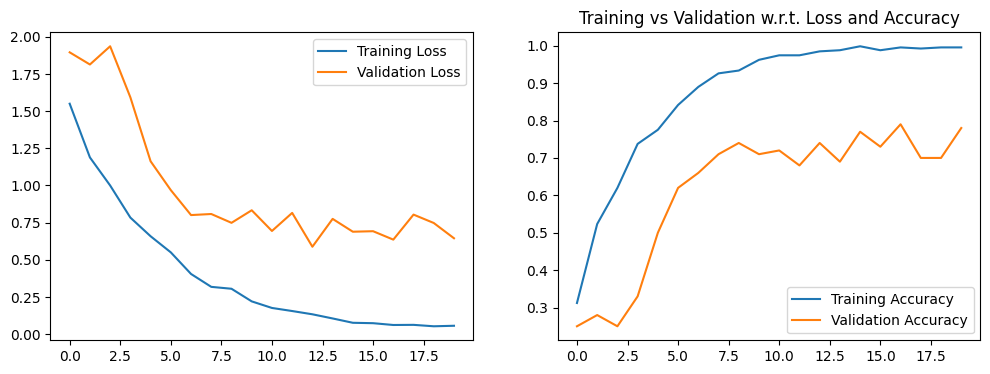

In [10]:
# Plotting Graph for Accuracy and Loss
plot(history_model11)

**Insights:**

1. It is overfitted model.
2. It is giving approx. 100% Training Accuracy and 75% Validation Accuracy.

## **Consolidated Final Models:**

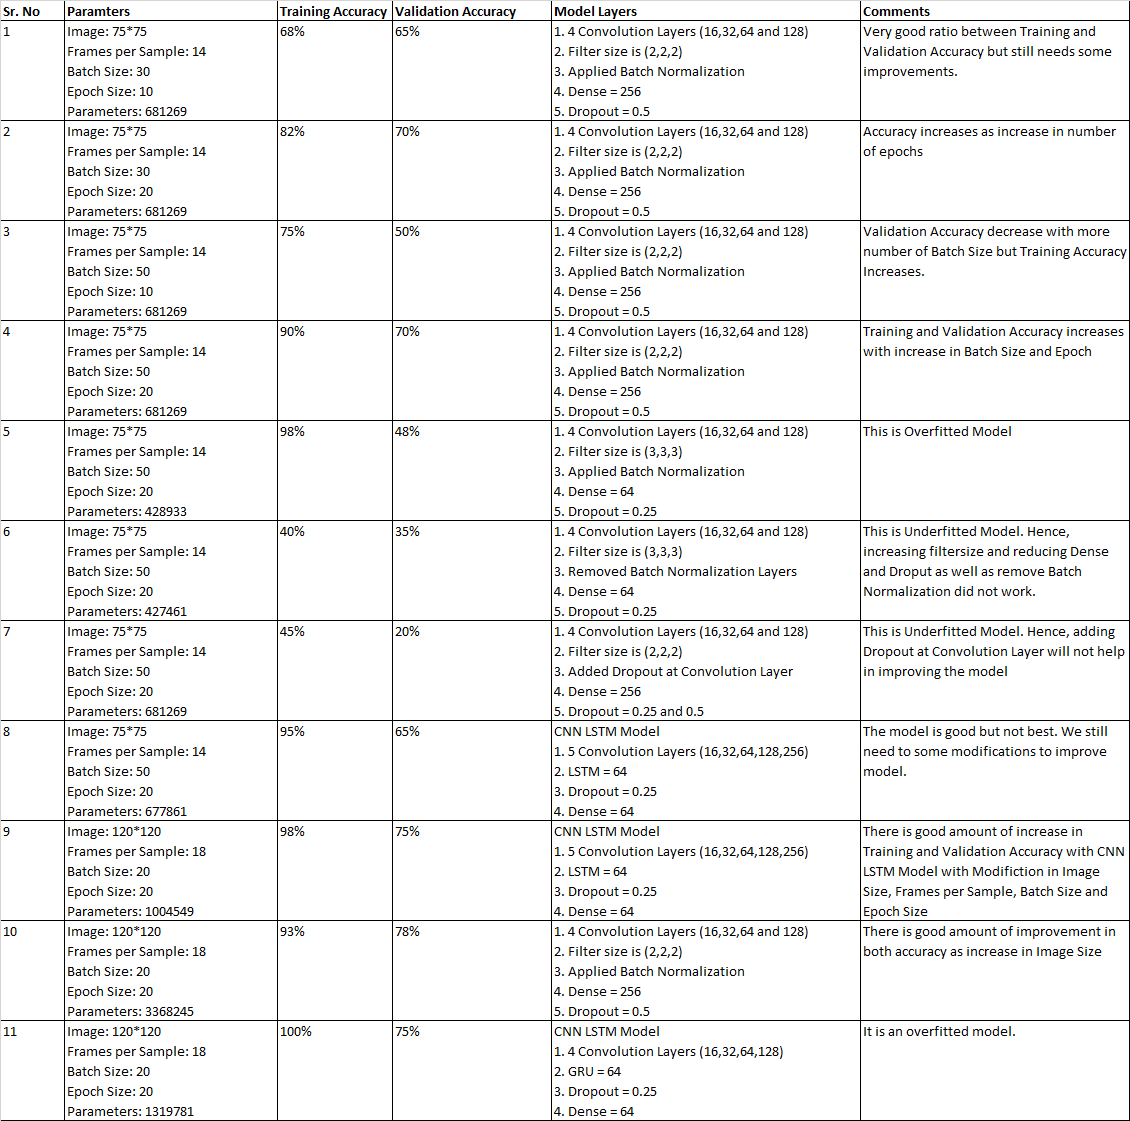

### **Recommended Model:**

1. We can use Model 9 and Model 10 as they are giving better Training and Validation Accuracy.
2. If we take number of parameters in consideration then Model 9 would be good choice.

### **The best weights of CNN-LSTM: model-00020-0.11618-0.98341-0.58072-0.78000.h5 (12 MB).**